# © Pierre-Henri Rossouw
# September 2023
# ✉ raxephion@gmail.com

# Stock (MOCHA_JAVA) LSTM Stock Price Forecasting

# Import Libraries

In [253]:
# Plots

import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plt.style.use('ggplot')

# Modelling and Forecasting

from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster

# LSTM

import pandas as pd
import yfinance as yf
from datetime import date, timedelta

import warnings
warnings.filterwarnings('ignore')

# Load Dataset and Define Dataframes

In [390]:


ticker = "NVDA"  #change ticker to desired stock/commodity
today = date.today()

d1 = today.strftime("%Y-%m-%d")
end_date = d1
d2 = date.today() - timedelta(days=5000)
d2 = d2.strftime("%Y-%m-%d")
start_date = d2

df1 = yf.download(ticker,                  
                      start=start_date, 
                      end=end_date, 
                      progress=False)
df1["Date"] = df1.index
df1 = df1[["Date", "Open", "High", "Low", "Close", "Adj Close", "Volume"]]
df1.reset_index(drop=True, inplace=True)

dfg=df1


print(df1.tail(10))      # Tail method = latest results
print(df1.head(10))


# Get values into variables to be used in prediction later on

o = df1.tail(1)[["Open"]] 
h = df1.tail(1)[["High"]]
l = df1.tail(1)[["Low"]]
v = df1.tail(1)[["Volume"]]
c = df1.tail(1)[["Close"]]



# New Addition: Assign a variable to the latest close price
latest_close_price = df1.iloc[-1]["Close"]
print(f"Latest Close Price: {latest_close_price}")

           Date        Open        High         Low       Close   Adj Close  \
3433 2024-09-16  116.790001  118.180000  114.360001  116.779999  116.779999   
3434 2024-09-17  118.169998  118.800003  114.830002  115.589996  115.589996   
3435 2024-09-18  115.889999  117.699997  113.220001  113.370003  113.370003   
3436 2024-09-19  117.349998  119.660004  117.250000  117.870003  117.870003   
3437 2024-09-20  117.059998  118.620003  115.389999  116.000000  116.000000   
3438 2024-09-23  116.550003  116.989998  114.860001  116.260002  116.260002   
3439 2024-09-24  116.519997  121.800003  115.379997  120.870003  120.870003   
3440 2024-09-25  122.019997  124.940002  121.610001  123.510002  123.510002   
3441 2024-09-26  126.800003  127.669998  121.800003  124.040001  124.040001   
3442 2024-09-27  123.970001  124.029999  119.260002  121.400002  121.400002   

         Volume  
3433  248772300  
3434  231925900  
3435  310318900  
3436  293506400  
3437  382462400  
3438  206228500  
3439

# Data Analysis

In [409]:
row_count = len(df1)
print(row_count)

3443


In [411]:
dfg.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2011-01-24,0.58100,0.62625,0.57450,0.61825,0.567027,2056900000
1,2011-01-25,0.61550,0.62200,0.59525,0.59925,0.549601,1086856000
2,2011-01-26,0.60550,0.62500,0.60125,0.61350,0.562671,1074660000
3,2011-01-27,0.62225,0.62375,0.60000,0.61175,0.561065,657396000
4,2011-01-28,0.61325,0.62350,0.58000,0.59400,0.544786,1094796000


# Analyze DataFrame

In [418]:
print(df1.describe())

                                Date         Open         High          Low  \
count                           3443  3443.000000  3443.000000  3443.000000   
mean   2017-11-24 17:16:23.909381376    12.728566    12.967206    12.470424   
min              2011-01-24 00:00:00     0.287250     0.290750     0.278750   
25%              2014-06-25 12:00:00     0.476250     0.481125     0.470875   
50%              2017-11-22 00:00:00     3.943750     3.997250     3.848000   
75%              2021-04-27 12:00:00    13.840000    14.042625    13.544500   
max              2024-09-27 00:00:00   139.800003   140.759995   132.419998   
std                              NaN    23.670262    24.129656    23.138204   

             Close    Adj Close        Volume  
count  3443.000000  3443.000000  3.443000e+03  
mean     12.730239    12.701718  4.787667e+08  
min       0.284500     0.260929  4.564400e+07  
25%       0.476125     0.450864  3.008780e+08  
50%       3.927750     3.896157  4.157880e+08  


# Shape is important for training

In [421]:
df1.shape

(3443, 7)

# Checking Types

In [425]:
df1.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object

# Checking Covariance of data

In [429]:
df1.cov()

,Date,Open,High,Low,Close,Adj Close,Volume
Date,1.553921e+34,1.984068e+18,2.022302e+18,1.942435e+18,1.984235e+18,1.984463e+18,-2.896262e+24
Open,1.984068e+18,5.602813e+02,5.710609e+02,5.475512e+02,5.595788e+02,5.596732e+02,-3.678072e+08
High,2.022302e+18,5.710609e+02,5.822403e+02,5.581793e+02,5.705810e+02,5.706773e+02,-3.640302e+08
Low,1.942435e+18,5.475512e+02,5.581793e+02,5.353765e+02,5.471777e+02,5.472702e+02,-3.736153e+08
Close,1.984235e+18,5.595788e+02,5.705810e+02,5.471777e+02,5.594387e+02,5.595331e+02,-3.708124e+08
Adj Close,1.984463e+18,5.596732e+02,5.706773e+02,5.472702e+02,5.595331e+02,5.596277e+02,-3.717160e+08
Volume,-2.896262e+24,-3.678072e+08,-3.640302e+08,-3.736153e+08,-3.708124e+08,-3.717160e+08,7.739544e+16


# Look at correlation of data

In [433]:
correlation = df1.corr()
print(correlation["Close"].sort_values(ascending=False))

Close        1.000000
Adj Close    1.000000
Low          0.999822
High         0.999747
Open         0.999498
Date         0.672980
Volume      -0.056353
Name: Close, dtype: float64


# Check for Null values and drop them

In [437]:
df1.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [439]:
df1 = df1.dropna()

# Check Shape again

In [443]:
df1.shape

(3443, 7)

# Drop Adj Close as its the same as Close

In [446]:
df1[df1['Close'] == df1['Adj Close']].shape

(12, 7)

In [448]:
df1 = df1.drop(['Adj Close'], axis=1)

# Check shape again

In [451]:
df1.shape

(3443, 6)

# Check either Head() or Tail() if dropping column was successful:

In [454]:
df1.head()
df1.tail()

,Date,Open,High,Low,Close,Volume
3438,2024-09-23,116.550003,116.989998,114.860001,116.260002,206228500
3439,2024-09-24,116.519997,121.800003,115.379997,120.870003,354966800
3440,2024-09-25,122.019997,124.940002,121.610001,123.510002,284692900
3441,2024-09-26,126.800003,127.669998,121.800003,124.040001,302582900
3442,2024-09-27,123.970001,124.029999,119.260002,121.400002,270161000


# Visualise Data

# Time-series Analysis:

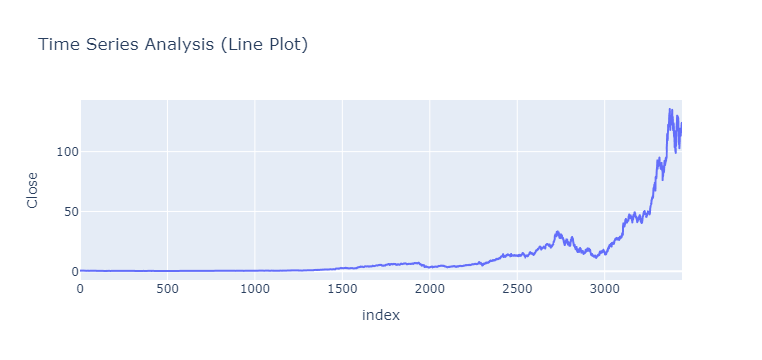

In [459]:
import plotly.express as px
figure = px.line(df1, x = df1.index, 
                 y = "Close", 
                 title = "Time Series Analysis (Line Plot)")
figure.show()

# Visualise Distinct features:

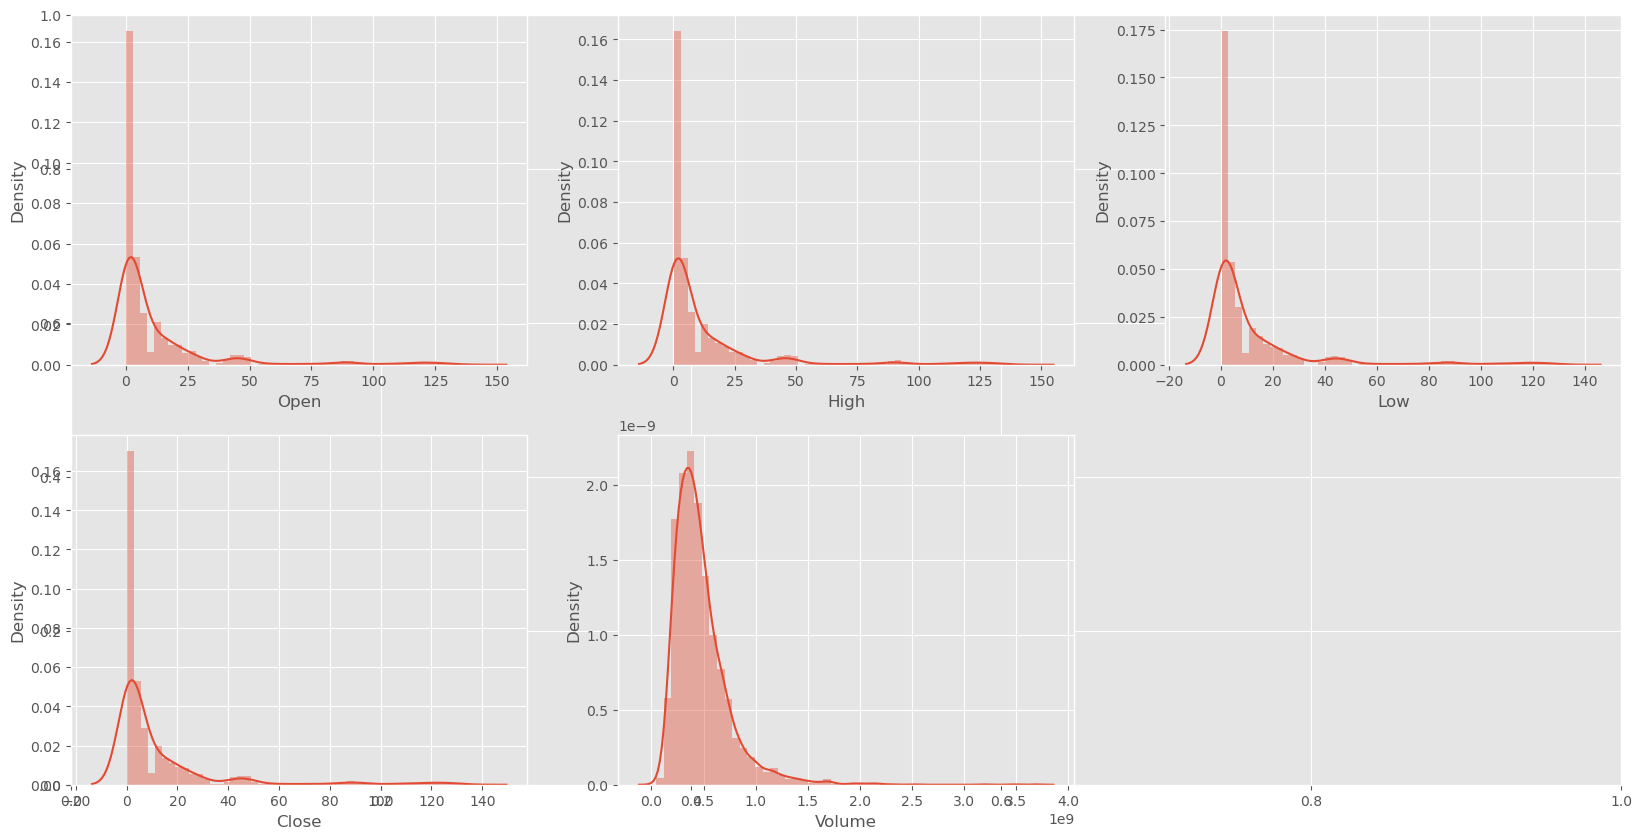

In [463]:
features = ['Open', 'High', 'Low', 'Close', 'Volume']

plt.subplots(figsize=(20,10))

for i, col in enumerate(features):
    plt.subplot(2,3,i+1)
    sns.distplot(df1[col])
plt.show()

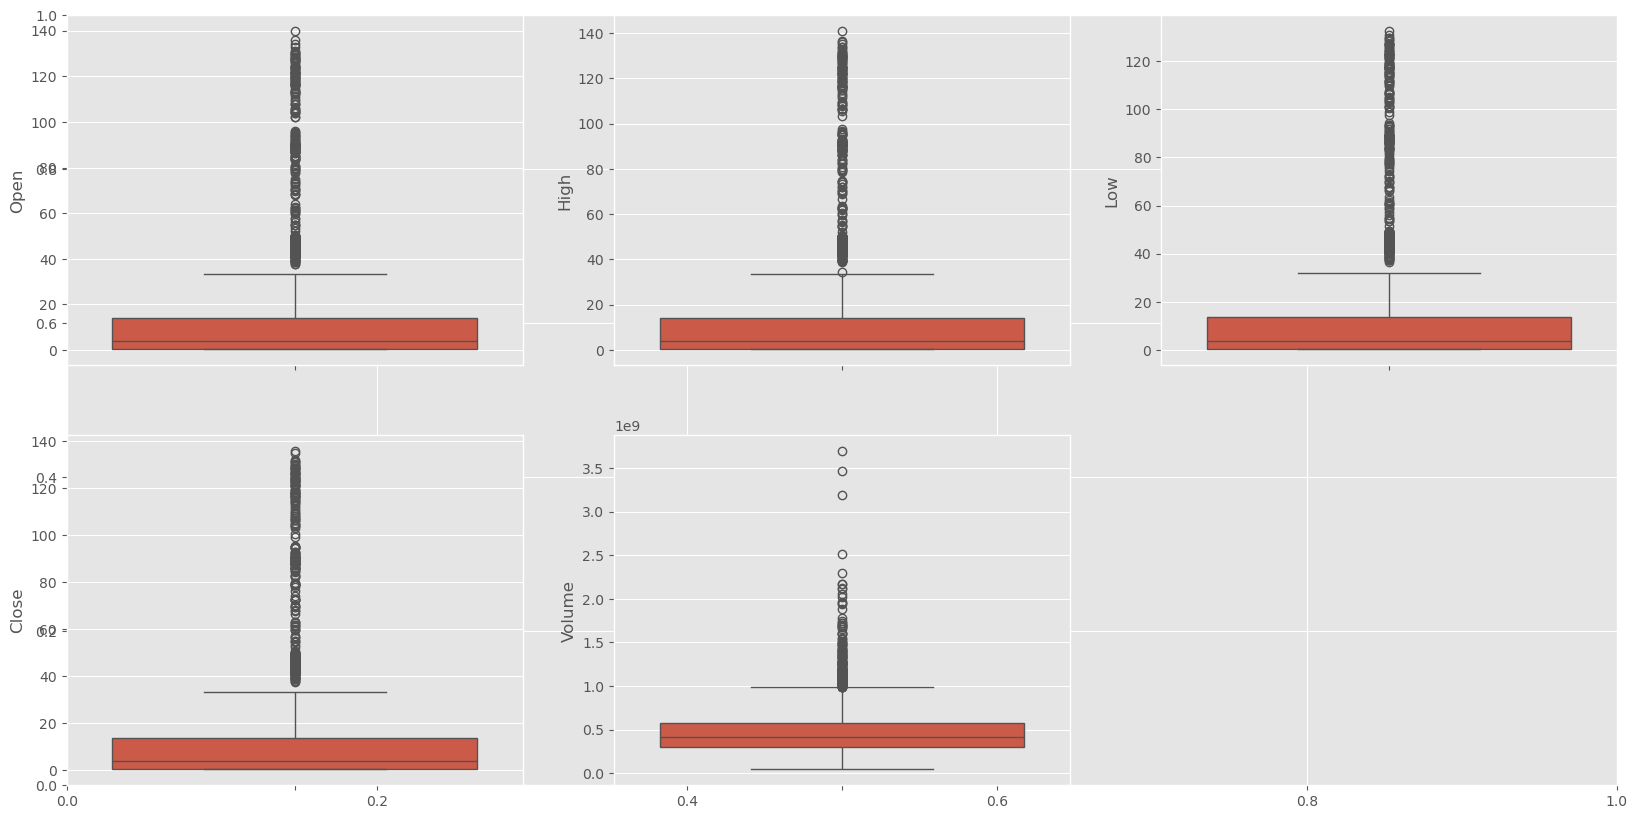

In [464]:
plt.subplots(figsize=(20,10))
for i, col in enumerate(features):
    plt.subplot(2,3,i+1)
    sns.boxplot(df1[col])
plt.show()

In [467]:

dfg['date'] = pd.to_datetime(dfg['Date'], format='%Y-%m-%d %H:%M:%S')
dfg = dfg.loc[:, ['date', 'Open', 'Close', 'High', 'Low']]
dfg = dfg.rename({'Open': 'open', 'Close': 'close', 'High': 'high', 'Low': 'low'}, 
                    axis=1)
dfg = dfg.set_index('date')
dfg = dfg.asfreq('D')
dfg = dfg.sort_index()

In [468]:
print(f'Number of rows with missing values: {dfg.isnull().any(axis=1).mean()}')

Number of rows with missing values: 0.31084867894315454


In [470]:
dfg = dfg.dropna()

# Locate corresponding data for each year

In [477]:
years = list(dfg.index.year.unique())
df_plot = pd.DataFrame()

for year in years:
    
    year_open  = dfg.loc[dfg.index.year == year, 'open'][0]
    year_close = dfg.loc[dfg.index.year == year, 'close'][-1]
    year_low   = dfg.loc[dfg.index.year == year, 'low'].min()
    year_high  = dfg.loc[dfg.index.year == year, 'high'].max()
    
    df_plot[year] = pd.Series([year_open, year_close, year_low, year_high]) 
    
df_plot = df_plot.T
df_plot = df_plot.set_axis(['open', 'close', 'low', 'high'], axis=1)

# Calculate % change between the open and close price of the year
# ==============================================================================
df_plot['year_change'] = 100*(df_plot['close'] - df_plot['open']) / df_plot['open']
df_plot.head(3)

,open,close,low,high,year_change
2011,0.5810,0.3465,0.28675,0.65425,-40.361441
2012,0.3575,0.3065,0.27875,0.42250,-14.265735
2013,0.3140,0.4005,0.29775,0.40800,27.547766


# Create a list of dicts with the % change annotations for the plot

In [481]:

annotations_list = []
max_high = df_plot['high'].max()

for year in years:
    
    df_aux = df_plot.loc[df_plot.index == year,]
    loc_x = pd.to_datetime(df_aux.index[0], format='%Y')
    loc_y = df_aux['high'].values[0]/max_high + 0.05
    text = '{:.1f}%'.format(df_aux['year_change'].values[0])
    
    annotation = dict(x=loc_x, y=loc_y, 
                      xref='x', yref='paper',
                      showarrow=False, xanchor='center', 
                      text=text)

    annotations_list.append(annotation)


# Interactive candlestick chart with Plotly

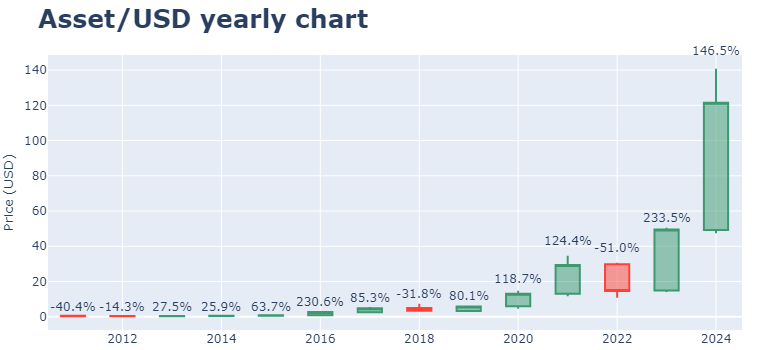

In [484]:

candlestick = go.Candlestick(
                    x     = pd.to_datetime(df_plot.index, format='%Y'),
                    open  = df_plot.open,
                    close = df_plot.close,
                    low   = df_plot.low,
                    high  = df_plot.high
                    )

fig = go.Figure(data=[candlestick])

fig.update_layout(
    width       = 800,
    height      = 350,
    title       = dict(text='<b>Asset/USD yearly chart</b>', font=dict(size=25)),
    yaxis_title = dict(text='Price (USD)', font=dict(size=13)),
    margin      = dict(l=0, r=20, t=55, b=20),
    xaxis_rangeslider_visible = False,
    annotations = annotations_list
    )

# Locate corresponding data for each month

In [487]:
years = list(dfg.index.year.unique())
df_plot = pd.DataFrame()

for year in years:
    for month in range(12):
        
        start_date = pd.to_datetime(f'{year}-{month+1}-01', format='%Y-%m-%d')
        end_date = (start_date + pd.offsets.MonthBegin())
        mask = (dfg.index >= start_date) & (dfg.index < end_date)
        
        if not dfg.loc[mask, :].empty:
                        
            month_open  = dfg.loc[mask, 'open'][0]
            month_close = dfg.loc[mask, 'close'][-1]
            month_low   = dfg.loc[mask, 'low'].min()
            month_high  = dfg.loc[mask, 'high'].max()
            
            serie  = pd.Series([month_open, month_close, month_low, month_high])
            df_aux = pd.DataFrame(serie, columns=[f'{str(month+1).zfill(2)}-{year}'])
            
            if df_plot.empty:
                df_plot = df_aux.copy()
            else:
                df_plot = pd.concat([df_plot, df_aux], axis=1)

df_plot = df_plot.T
df_plot = df_plot.set_axis(['open', 'close', 'low', 'high'], axis=1)

# Creating colour Palette

In [490]:

palette_asset = {'orange': '#f7931a',
               'white' : '#ffffff',
               'gray'  : '#4d4d4d',
               'blue'  : '#0d579b',
               'green' : '#329239'
              }

# Boxplot chart for annual seasonality

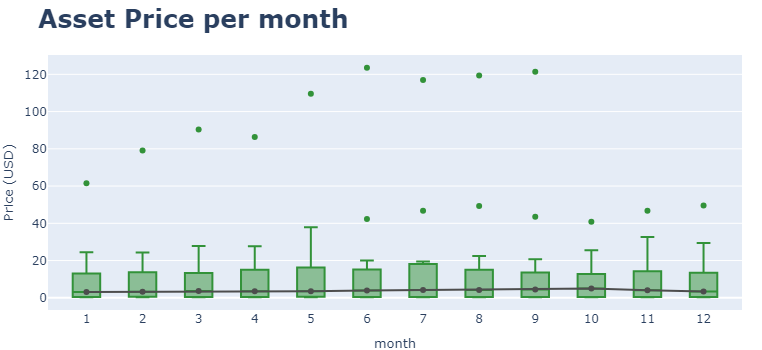

In [493]:

df_plot['month'] = pd.to_datetime(df_plot.index, format='%m-%Y').month

# fig 1 monthly boxplot
fig1 = px.box(df_plot.sort_values('month'), x='month', y='close',
              color_discrete_sequence=[palette_asset['green']])

# fig 2 line with median data for each month
df_median = pd.DataFrame(df_plot.groupby('month')['close'].median()).reset_index()
fig2 = px.line(df_median, x='month', y='close', markers=True,
               color_discrete_sequence=[palette_asset['gray']])

fig = go.Figure(data=fig1.data + fig2.data)

fig.update_layout(
    width       = 650,
    height      = 350,
    title       = dict(text='<b>Asset Price per month</b>', font=dict(size=25)),
    yaxis_title = dict(text='Price (USD)', font=dict(size=13)),
    xaxis       = dict(tickmode='linear'),
    xaxis_title = dict(text='month', font=dict(size=13)),
    margin      = dict(l=0, r=20, t=55, b=20)
    )

fig.show()

# Boxplot chart for monthly seasonality

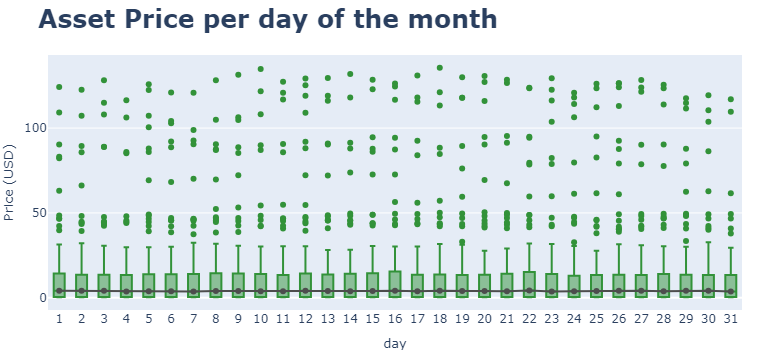

In [496]:

dfg['day'] = pd.Series(dfg.index).dt.day.values

# fig 1 dayly boxplot
fig1 = px.box(dfg.sort_values('day'), x='day', y='close',
              color_discrete_sequence=[palette_asset['green']])

# fig 2 line with median data for each day
df_median = pd.DataFrame(dfg.groupby('day')['close'].median()).reset_index()
fig2 = px.line(df_median, x='day', y='close', markers=True,
               color_discrete_sequence=[palette_asset['gray']])

fig = go.Figure(data=fig1.data + fig2.data)

fig.update_layout(
    width       = 750,
    height      = 350,
    title       = dict(text='<b>Asset Price per day of the month</b>', font=dict(size=25)),
    yaxis_title = dict(text='Price (USD)', font=dict(size=13)),
    xaxis       = dict(tickmode='linear', tickangle=0, range=[0.5, 31.5]),
    xaxis_title = dict(text='day', font=dict(size=13)),
    margin      = dict(l=0, r=20, t=55, b=20)
    )

fig.show()

# Boxplot chart for weekly seasonality

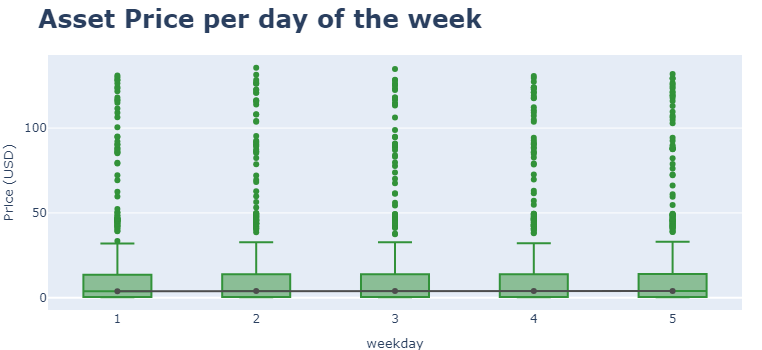

In [499]:

dfg['weekday'] = dfg.index.day_of_week + 1

# fig 1 weekly boxplot
fig1 = px.box(dfg.sort_values('weekday'), x='weekday', y='close',
              color_discrete_sequence=[palette_asset['green']])

# fig 2 line with median data for each weekday
df_median = pd.DataFrame(dfg.groupby('weekday')['close'].median()).reset_index()
fig2 = px.line(df_median, x='weekday', y='close', markers=True,
               color_discrete_sequence=[palette_asset['gray']])

fig = go.Figure(data=fig1.data + fig2.data)

fig.update_layout(
    width       = 650,
    height      = 350,
    title       = dict(text='<b>Asset Price per day of the week</b>', font=dict(size=25)),
    yaxis_title = dict(text='Price (USD)', font=dict(size=13)),
    xaxis       = dict(tickmode='linear'),
    xaxis_title = dict(text='weekday', font=dict(size=13)),
    margin      = dict(l=0, r=20, t=55, b=20)
    )

fig.show()

# Autocorrelation plot

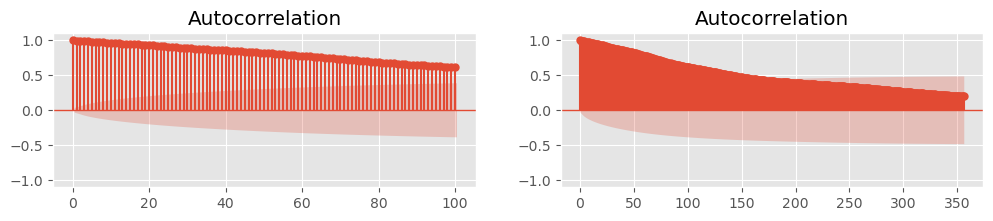

In [502]:

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,2))
axes = axes.flat
plot_acf(dfg.close, ax=axes[0], linewidth = 1, lags=100)
axes[0].set_ylim(-1.1, 1.1)
plot_acf(dfg.close, ax=axes[1], linewidth = 1, lags=356)
axes[1].set_ylim(-1.1, 1.1)
plt.show();

In [504]:
# Partial autocorrelation plot

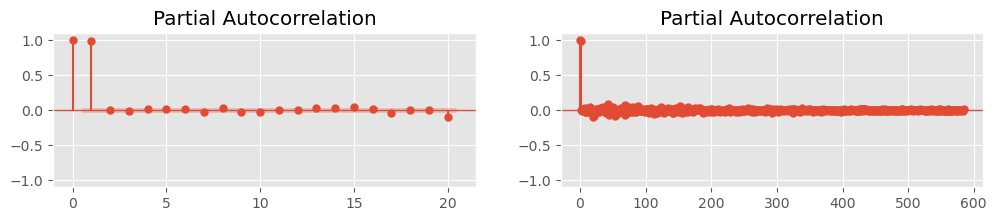

In [506]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 2))
axes = axes.flat
plot_pacf(dfg.close, ax=axes[0], lags=20, method='ywm',  linewidth = 1)
axes[0].set_ylim(-1.1, 1.1)
plot_pacf(dfg.close, ax=axes[1], lags=585, method='ywm',  linewidth = 1)
axes[1].set_ylim(-1.1, 1.1)
plt.show();

# Fitting values for the Neural Network (LSTM)

In [509]:
x = df1[["Open", "High", "Low", "Volume"]]
y = df1["Close"]
x = x.to_numpy()
y = y.to_numpy()
y = y.reshape(-1, 1)

from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(x, y, 
                                                test_size=0.2, 
                                               random_state=42)

# Prepping the Neural Network prior to training

In [511]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (xtrain.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))





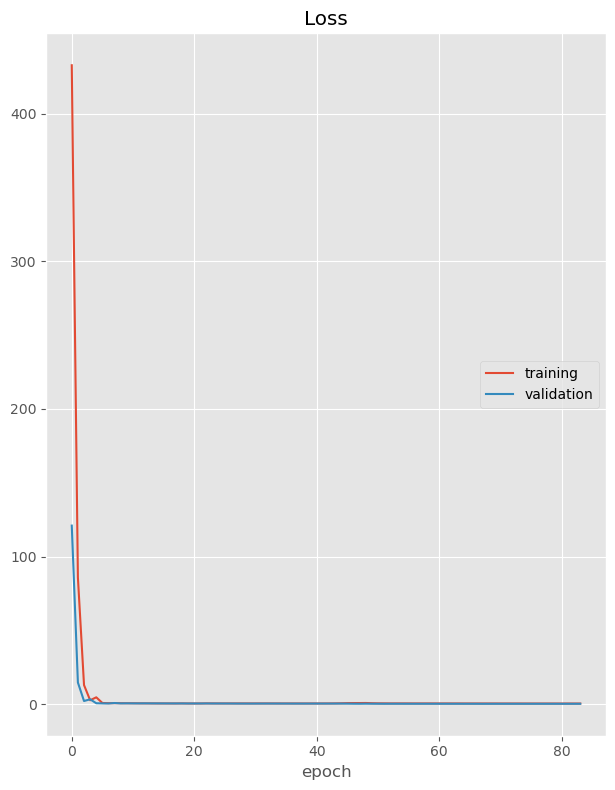

Loss
	training         	 (min:    0.475, max:  432.685, cur:    0.475)
	validation       	 (min:    0.297, max:  120.969, cur:    0.310)
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4812 - val_loss: 0.3098


In [516]:

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')
# Train the model
# model.fit(xtrain, ytrain, batch_size=1, epochs=1) # OLD

from keras.callbacks import EarlyStopping

stop_here_please = EarlyStopping(patience=16, monitor="val_loss",restore_best_weights=True)


from livelossplot import PlotLossesKeras 
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(xtrain, ytrain, batch_size=32, epochs=100, validation_data=(xtest, ytest),callbacks=([PlotLossesKeras()], [stop_here_please]), shuffle = False,verbose =1)



# Forecasting the next "Close" price:

In [521]:
# Feature array for making a prediction (single sample with 4 features)
features = np.array([[o, h, l, v]])
print("Feature shape:", features.shape)
predicted_latest = model.predict(features)
print("Forecasting for the next 'closing' price of", ticker ,"is", predicted_latest)
if predicted_latest > latest_close_price:
    print("Therefore, forecasting for", ticker, "shows an INCREASE in the next 'close' price")
else:
    print("Therefore, forecasting for", ticker, "shows a DECREASE in the next 'close' price")

Feature shape: (1, 4, 1, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
Forecasting for the next 'closing' price of NVDA is [[123.06604]]
Therefore, forecasting for NVDA shows an INCREASE in the next 'close' price
